## Importing alevin data with tximeta

We will use *tximeta* to import the *alevin* counts into
R/Bioconductor. The main function `tximeta` reads information from the
entire output directory of *alevin* or *Salmon* in order to
automatically detect and download metadata about the reference
sequences (the transcripts). It should work "out of the
box" for human, mouse, and fruit fly reference transcripts from
GENCODE, Ensembl, or RefSeq.

First we specify the path where the quantification data is stored. In
this tutorial, the data is already copied to your environment.

**Note:** For typical use, you would just specify the path to the directory 
of the output from *alevin*.

**Note:** when sharing *alevin* or *Salmon* datasets, make sure
to share the entire output directory (you can `zip` or `tar` the
directories to make them into a single share-able file).

We make a vector called `files` (for *alevin* this will point to just
a single file, but with *Salmon* usually one would import multiple
files at a time).

In [1]:
dir <- "data/pbmc_1k/pbmc_1k"
files <- file.path(dir, "alevin", "quants_mat.gz")
file.exists(files)

[1] TRUE

We can import the *alevin* quantification using the following call to
`tximeta`. The extra argument to *alevin* will filter out cells based
on *alevin*'s post-quantification quality control methods (see paper
for details).

In [2]:
suppressPackageStartupMessages(library(GenomicFeatures))
library(tximeta)
se <- tximeta(files, type="alevin", alevinArgs=list(filterBarcodes=TRUE))

importing quantifications

reading in alevin gene-level counts across cells with fishpond

filtering down to 1142 cell barcodes

reading in alevin inferential variance with fishpond

found matching transcriptome:
[ GENCODE - Homo sapiens - release 33 ]

building TxDb with 'GenomicFeatures' package

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK

generating gene ranges

generating gene ranges

fetching genome info for GENCODE



We can see as it was importing that it automatically detected we are
working with data quantified using GENCODE's *Homo sapiens* reference
transcripts, release 33. The transcript metadata was added
programmatically to the output (this object, `se`). `tximeta` is also
written in such a way that it will avoid unnecessary downloads and
parsing of files -- it will first attempt to find a cached version of
the metadata, to avoid re-downloading or re-parsing these files.

`tximeta` returns a *SummarizedExperiment*. We can
easily convert this object into a *SingleCellExperiment*
which has specific slots designed for single-cell
experiment data.

In [3]:
suppressPackageStartupMessages(library(SingleCellExperiment))
sce <- as(se, "SingleCellExperiment")

The SingleCellExperiment object is used widely across Bioconductor packages (as you may already know), and so the code up to this point can be used as an entry point into other Bioconductor single cell workflows. For more details on working with SingleCellExperiment objects, one can consult the following online book: Orchestrating Single-Cell Analysis with Bioconductor [@Amezquita2020].

In [19]:
library(org.Hs.eg.db)
sce <- addIds(sce, "SYMBOL")



mapping to new IDs using 'org.Hs.eg.db' data package
if all matching IDs are desired, and '1:many mappings' are reported,
set multiVals='list' to obtain all the matching IDs

it appears the rows are gene IDs, setting 'gene' to TRUE

'select()' returned 1:many mapping between keys and columns



## Add cell annotations

Cell annotations were already generated using *Seurat* [@seurat]. The
script is saved in this package in `inst/scripts/seurat.R`. Here we
will use them for size factor estimation and for visualization.


In [20]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))

# create seurat object for whitelisted cells
cts <- assays(sce)[["counts"]]
pbmc <- CreateSeuratObject(cts)
pbmc

An object of class Seurat 
60233 features across 1142 samples within 1 assay 
Active assay: RNA (60233 features, 0 variable features)

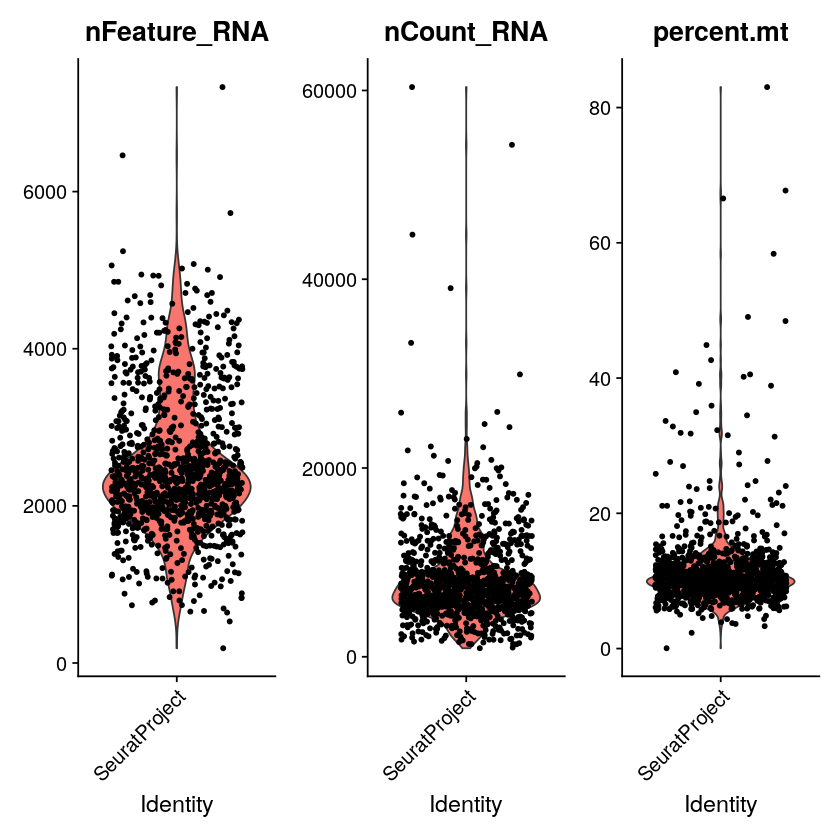

In [21]:
mt.genes <- rownames(sce)[as.logical(seqnames(sce) == "chrM")]
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, features = mt.genes)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [22]:
# filtering some outlier cells
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 20 & nCount_RNA < 20000)
pbmc

An object of class Seurat 
60233 features across 1068 samples within 1 assay 
Active assay: RNA (60233 features, 0 variable features)

In [23]:
# Normalize and runPCA
pbmc <- FindVariableFeatures(pbmc) %>%  NormalizeData() %>%  ScaleData() %>% RunPCA()

Centering and scaling data matrix

PC_ 1 
Positive:  ENSG00000227507.2, ENSG00000247774.7, ENSG00000277734.8, ENSG00000198851.10, ENSG00000211772.11, ENSG00000167286.9, ENSG00000182866.17, ENSG00000008517.16, ENSG00000168685.15, ENSG00000081059.20 
	   ENSG00000160654.10, ENSG00000127152.18, ENSG00000110848.8, ENSG00000139193.3, ENSG00000198821.10, ENSG00000185885.16, ENSG00000188042.8, ENSG00000111716.14, ENSG00000173762.8, ENSG00000107742.13 
	   ENSG00000273154.3, ENSG00000116824.5, ENSG00000197540.8, ENSG00000211751.9, ENSG00000237943.7, ENSG00000142546.14, ENSG00000013725.14, ENSG00000069667.16, ENSG00000054654.17, ENSG00000115085.13 
Negative:  ENSG00000090382.7, ENSG00000101439.9, ENSG00000163220.11, ENSG00000085265.11, ENSG00000163563.8, ENSG00000127951.7, ENSG00000163131.11, ENSG00000143546.10, ENSG00000204472.13, ENSG00000025708.14 
	   ENSG00000197746.14, ENSG00000038427.16, ENSG00000121552.4, ENSG00000197249.14, ENSG00000116701.14, ENSG00000110077.14, ENSG00000136826.15, EN

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1068
Number of edges: 41033

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9546
Number of communities: 5
Elapsed time: 0 seconds


01:18:54 UMAP embedding parameters a = 0.9922 b = 1.112

01:18:54 Read 1068 rows and found 25 numeric columns

01:18:54 Using Annoy for neighbor search, n_neighbors = 30

01:18:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

01:18:54 Writing NN index file to temp file /tmp/RtmpvB1bhz/filee8d3634800a

01:18:54 Searching Annoy index using 1 thread, search_k = 3000

01:18:54 Annoy recall = 100%

01:18:56 Commencing smooth kNN distance calibration using 1 thread

01:18:58 Initializing from normalized Laplacian + noise

01:18:58 Commencing optimization for 500 epochs, with 43362 positive edges

01:19:00 Optimization finished



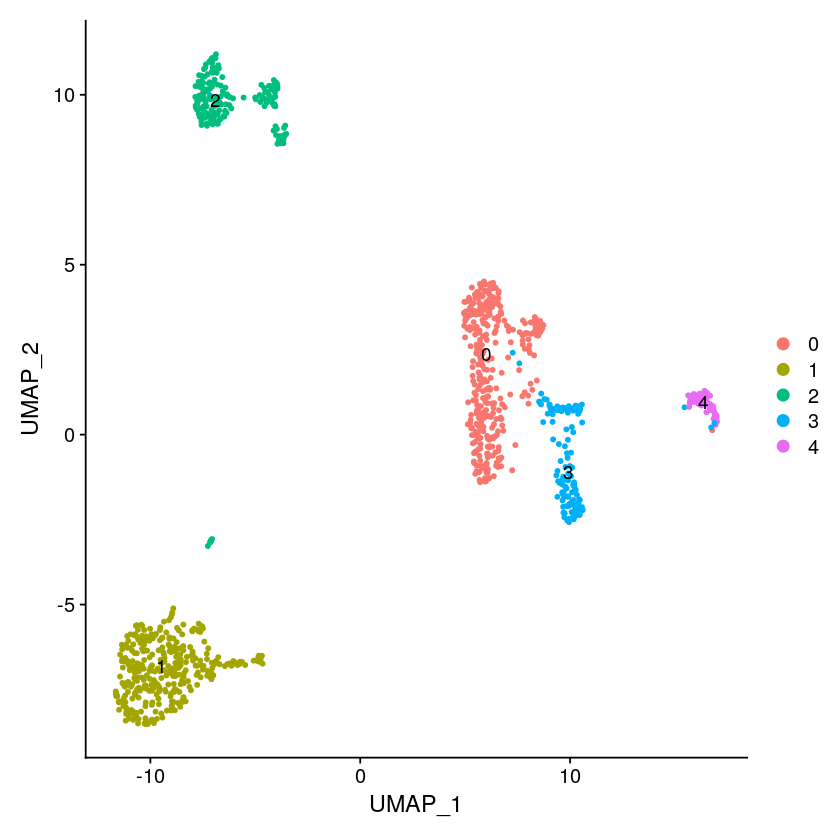

In [24]:
# Cluster the cells
pbmc <- FindNeighbors(pbmc, dims = 1:25)
pbmc <- FindClusters(pbmc, resolution = 0.15)

# plotting umap embeddings
pbmc <- RunUMAP(pbmc, dims = 1:25)
DimPlot(pbmc, label = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



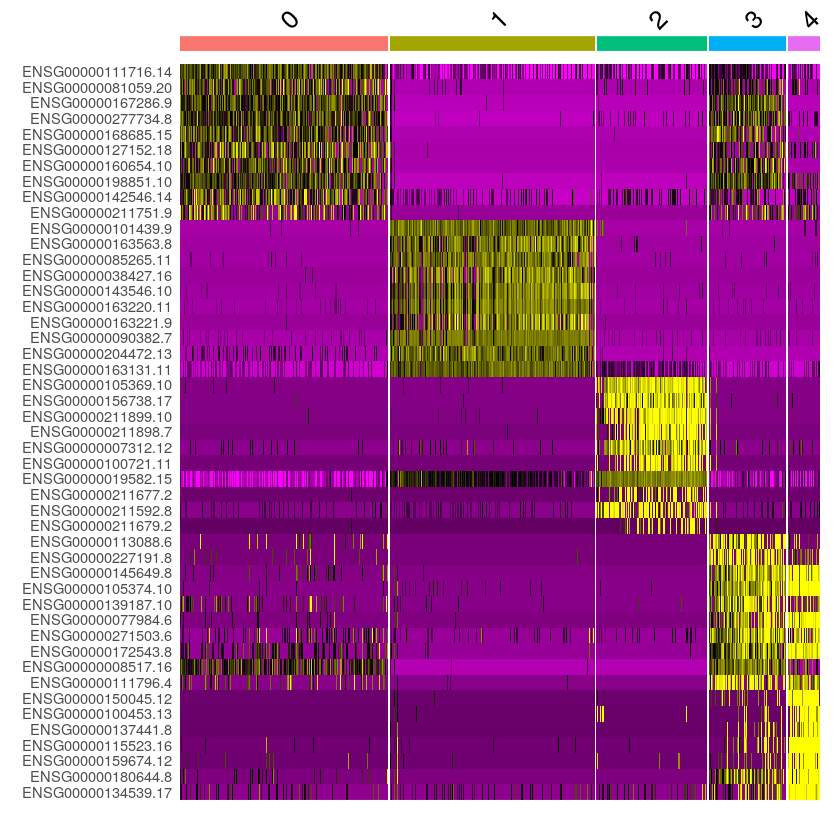

In [25]:
# Find marker genes & extract top 10 genes
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()
top10$symbol <- mcols(sce)[top10$gene,"SYMBOL"]

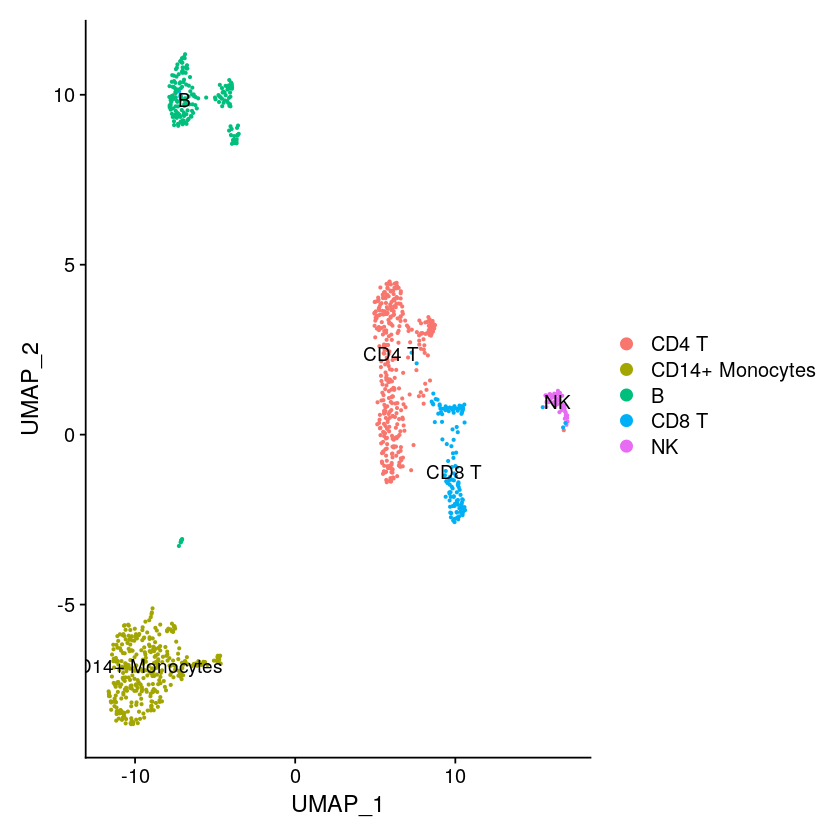

In [42]:
# Assigning Cluster names based on marker genes
# "CD14+ Monocytes" "CST3" "ENSG00000101439.9"
# "CD4 T" "IL7R" "ENSG00000168685.15"
# "B" "MS4A1" "ENSG00000156738.17"
# "CD8 T" "KLRB1" "ENSG00000111796.4" (we use only for this particular set of cells)
# "NK" "GNLY" "ENSG00000115523.16"

markers.vec <- c("CD14+ Monocytes"="ENSG00000101439.9", "CD4 T"="ENSG00000168685.15", "B"="ENSG00000156738.17", "CD8 T"="ENSG00000111796.4", "NK"="ENSG00000115523.16")
clusters <- character(5)
for (i in seq_along(markers.vec)) {
  idx <- which(top10$gene == markers.vec[i])
  stopifnot(length(idx) == 1)
  cluster.idx <- as.numeric(as.character(top10$cluster[idx])) + 1
  clusters[cluster.idx] <- names(markers.vec)[i]
}

top10$cluster.name <- rep(clusters, each=10)
df <- as.data.frame(top10)
# write.csv(df, file="../extdata/top10.csv")

names(clusters) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, clusters)
# saveRDS(Idents(pbmc), file="../extdata/idents.rds")

DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) 

In [28]:
ids <- readRDS(file.path("data/pbmc_1k", "idents.rds"))
top10 <- read.csv(file.path("data/pbmc_1k", "top10.csv"))

We subset to the cells that we have IDs for, and attach the labels in
the correct order:

In [30]:
idx <- colnames(sce) %in% names(ids)
table(idx)
sce <- sce[,idx]
sce$cluster <- ids[colnames(sce)]

idx
FALSE  TRUE 
   74  1068 

The number of cells per cluster:

In [31]:
table(sce$cluster)


          CD4 T CD14+ Monocytes               B           CD8 T              NK 
            346             346             189             133              54 

We have a data.frame with the top marker genes per cluster, as
identified with *Seurat*.

In [32]:
head(top10)

,X,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene,symbol,cluster.name
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,1,3.399988e-135,1.2134065,0.997,0.602,6.075778e-131,0,ENSG00000111716.14,LDHB,CD4 T
2,2,2.755855e-116,1.0112296,0.879,0.177,4.924713e-112,0,ENSG00000081059.20,TCF7,CD4 T
3,3,4.214635e-114,0.9936307,0.968,0.194,7.531553e-110,0,ENSG00000167286.9,CD3D,CD4 T
4,4,1.644166e-111,0.9595734,0.855,0.154,2.938125e-107,0,ENSG00000127152.18,BCL11B,CD4 T
5,5,9.344999e-110,1.0665597,0.980,0.266,1.669951e-105,0,ENSG00000277734.8,NA,CD4 T
6,6,2.602057e-105,1.1441765,0.916,0.175,4.649875e-101,0,ENSG00000168685.15,IL7R,CD4 T


## Plotting counts with uncertainty

In this section, we will begin to plot the counts for cells, for
specific genes, and showing the *inferential uncertainty* as
quantified by *alevin*. This is a unique aspect to the *alevin*
quantification method, that it retains gene multi-mapping reads,
instead of discarding these reads. *alevin* can also attach a measure
of uncertainty to each count in the matrix. *alevin* computes the mean
and variance of *inferential replicates* which are generated by
bootstrapping the read data. `tximeta` will import these inferential
mean and variance matrices by default (they are also sparse, similar
to the counts matrix).

We will first visualize the uncertainty, and later give an
example of a set of genes where the uncertainty is indicating
significant quantification uncertainty which is useful to consider
when performing EDA (exploratory data analysis) or statistical
analysis.

For a later demonstration of scaling, we will sort the cells by the
total count (this is not something you would necessarily do in a
typical analysis).

In [33]:
o <- order(colSums(assays(sce)[["counts"]]), decreasing=TRUE)
sce <- sce[,o]

We can now use a plotting function `plotInfReps` from the *fishpond*
package in order to plot the inferential mean and variance for the
cells, for various genes.

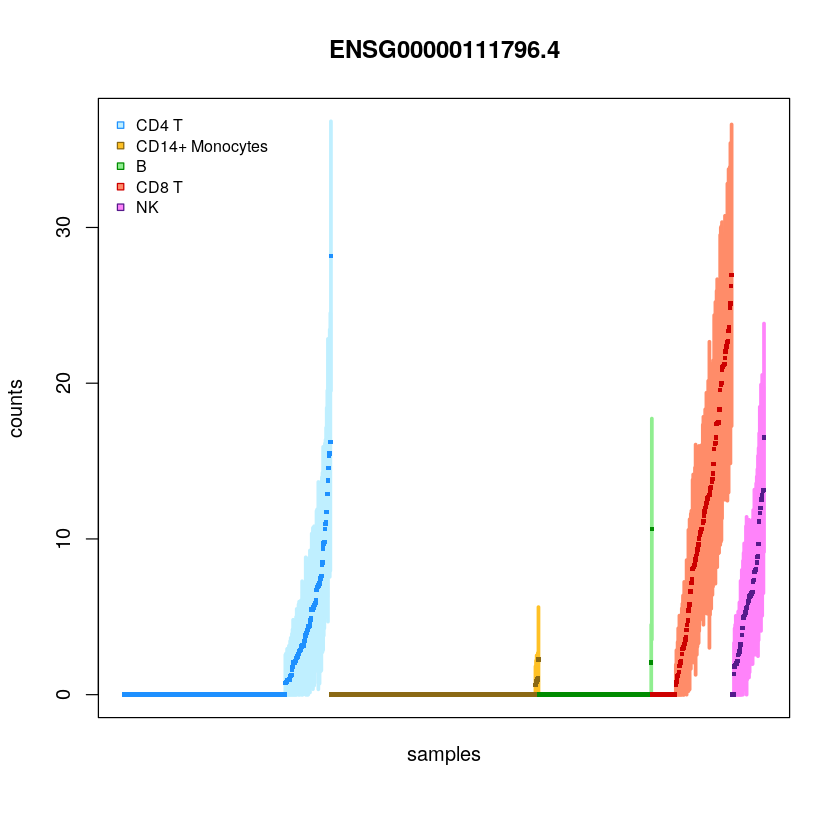

In [49]:
library(fishpond)
plotInfReps(sce, idx="ENSG00000111796.4",
            x="cluster",
            legend=TRUE, reorder = T)

Here, we have x as a grouping variable for coloring the points, one can also specify x to be a continuous covariate, e.g. pseudo-time. An additional covariate cov can be used for additional grouping, e.g. batches, donors or lineages.

Here we show the same plot but now subsetting the number of cells:

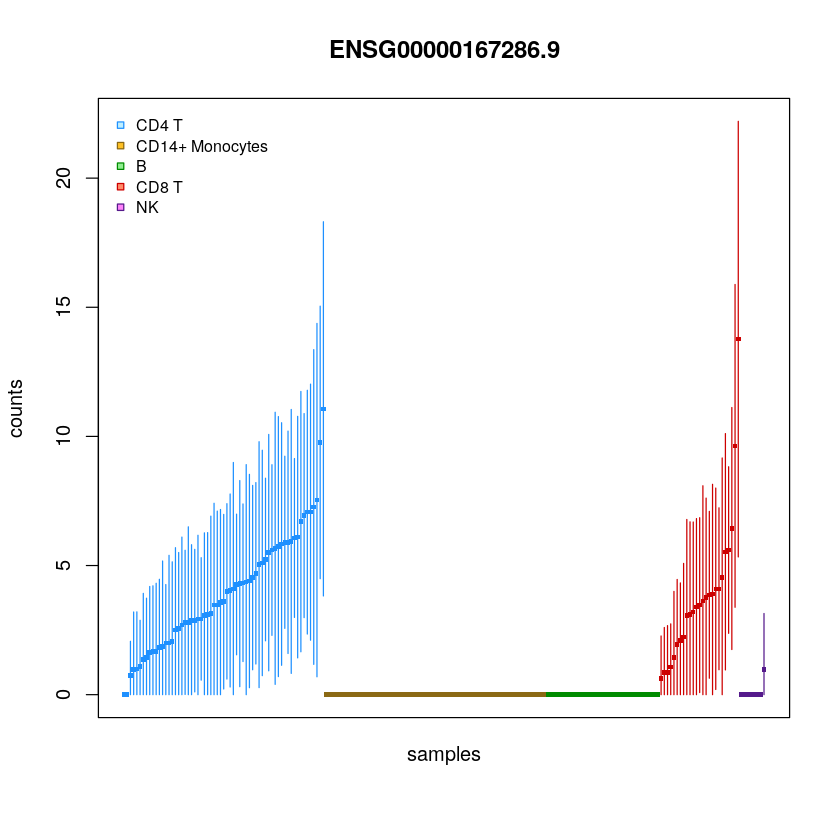

In [43]:
idx <- sample(ncol(sce),200)
plotInfReps(sce[,idx],
            idx="ENSG00000167286.9",
            x="cluster",
            legend=TRUE, reorder = T)

This time only 100 cells:

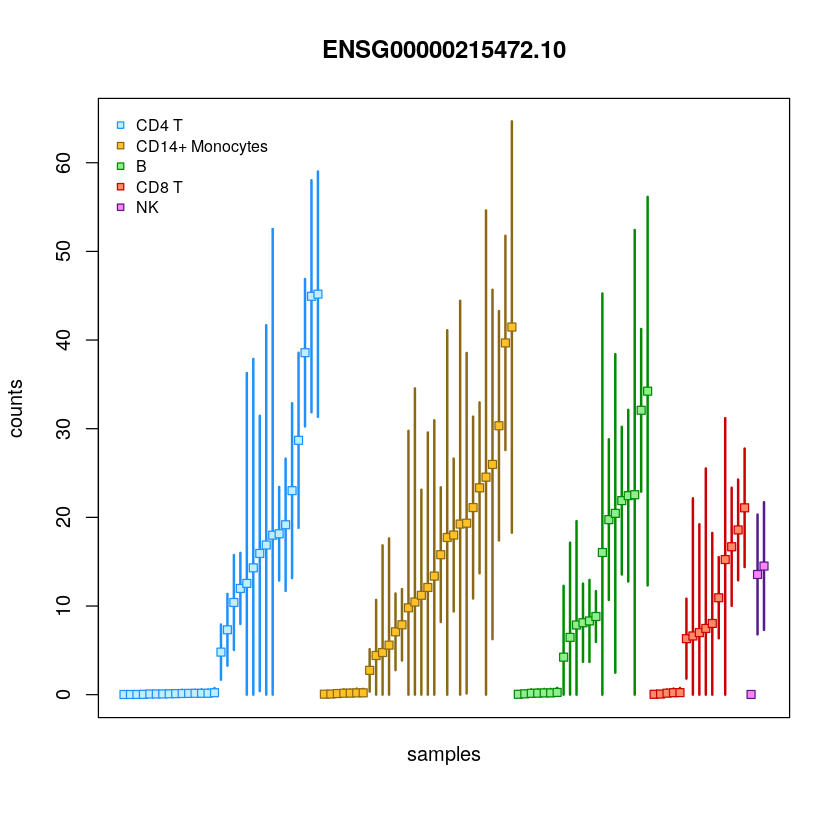

In [55]:
idx <- sample(ncol(sce),100)
plotInfReps(sce[,idx],
            idx="ENSG00000215472.10",
            x="cluster",
            legend=TRUE, reorder = T)

The plots change their features across different sample sizes for ease of viewing the uncertainty of quantification for individual cells.

We can also choose to plot the cells in their original order (the default for scRNA-seq is to sort by the mean value):

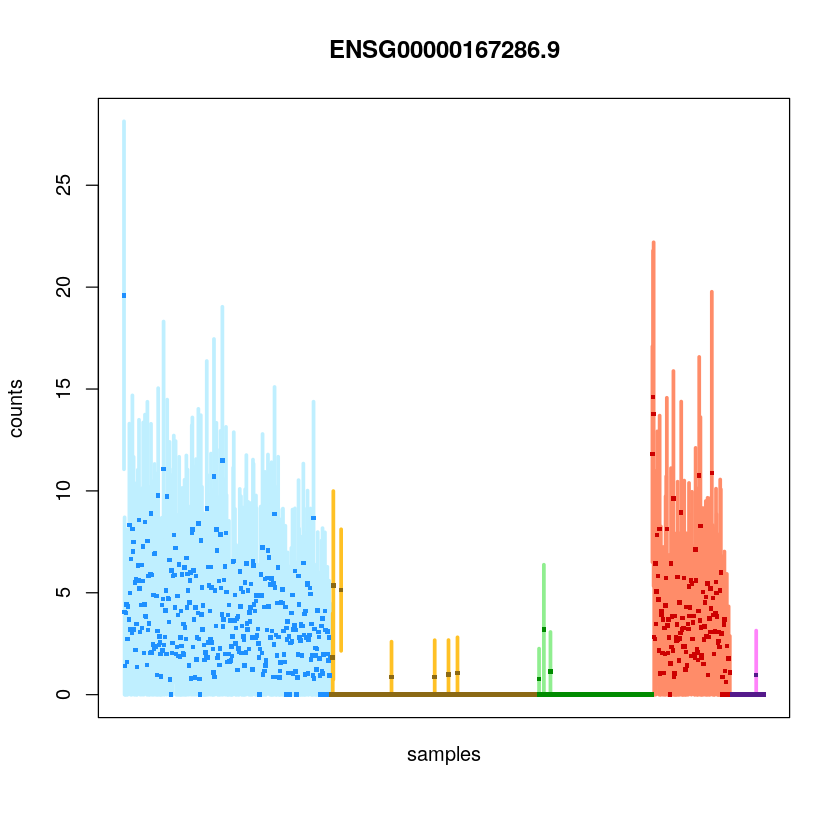

In [46]:
plotInfReps(sce, idx="ENSG00000167286.9",
            x="cluster",
            reorder=FALSE)

## Inferential variance (uncertainty)

In this second to last section, we will briefly talk about how the
inferential uncertainty as stored in the variance assay may be useful
in practice.

Many users may prefer to just work with the counts matrix, and not
consider the inferential mean and variance. We have found that,
globally, this may not lead to too much of a problem, but for certain
genes, it may be important to use the inferential variance in cases
where it may signal difficult to quantify genes. Inferential
uncertainty for bulk and single cell RNA-seq differential expression
was a focus of the *Swish* nonparametric statistical method [@swish]
which we do not demonstrate here, but one can refer to
the vignette of [swish](https://bioconductor.org/packages/swish) for
more details (in particular the section on *alevin* data).

Let's start by visualizing the uncertainty across all values in the
matrix: 

In [52]:
var <- as.vector(assays(sce)[["variance"]])
mu <- as.vector(assays(sce)[["mean"]])
idx <- mu > 3
df <- data.frame(log10mean=log10(mu[idx]),
                 log10var=log10(var[idx]))

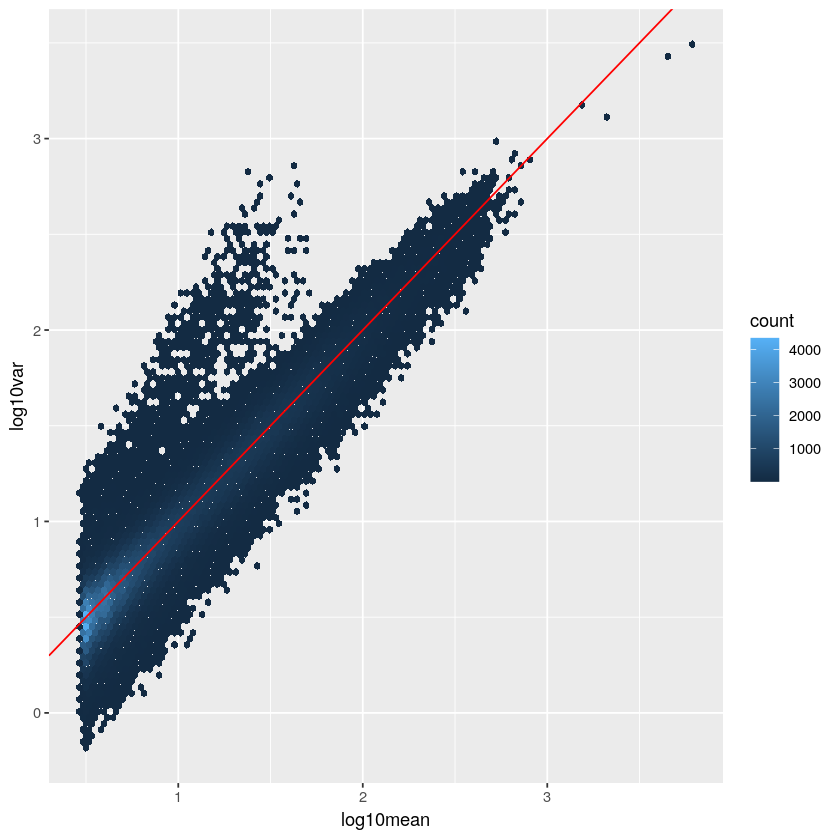

In [53]:
library(ggplot2)
ggplot(df, aes(log10mean, log10var)) +
  geom_hex(bins=100) + 
  geom_abline(intercept=0, slope=1, col="red")